# PROYECTO 1

 ## API : Last.fm
 
 Documentación : https://www.last.fm/api#getting-started

## 00. ETL

En programación, extraer, transformar, cargar (Extraction, Transform, Load - ETL) es un proceso de tres fases en el que los datos se extraen, transforman y cargan en un contenedor de datos (Bases de Datos, csv, spreadsheets…). Los datos se pueden recopilar de una o más fuentes y también se pueden enviar a uno o más destinos.

Para este proyecto vamos a realizar las 3 fases de este proceso, usando Python y todas las herramientas que hemos visto. Además vamos a agregar dos partes extras: Visualization y Storytelling.

El tema o tópico del proyecto lo elige el equipo y se recomienda que sea un tema en la que se tenga algo de conocimiento o interés.

In [1]:
import numpy as np
import pandas as pd

from time import sleep
from time import time

import requests
from bs4 import BeautifulSoup

from pprint import pprint

import matplotlib.pyplot as plt

from IPython.display import clear_output

## 01. Extraction

Para la extracción de datos vamos a utilizar 2 herramientas:

- Web Scraping
- APIs

El principal objetivo de esta parte es:

- Automatización de extracción de datos.

Para la automatización debemos hacer un código reutilizable (o función) que pueda ser utilizado para extraer información de la misma fuente y, si aplica, hacer la misma extracción usando diferentes parámetros de búsqueda.

Esta parte puede ser la que tome más tiempo dependiendo de la escala (o alcance) a la que queramos llevar el proyecto o el número de fuentes de las cuales queremos extraer datos.

In [2]:
API_KEY = "YOUR_API_KEY"
API_SECRET = "YOUR_API_SECRET"
USER_AGENT = "YOUR_USER_AGENT"

base_url = "https://ws.audioscrobbler.com/2.0/"

In [3]:
df_paises = pd.read_csv("paises_geo.csv").iloc[16:]

In [4]:
lista_paises = df_paises["etiqueta"].tolist()

In [5]:
def extraer_datos(cantidad_artistas, nacion):

    ##### CADA PÁGINA CONTIENE 50 ARTISTAS
    cantidad_paginas = cantidad_artistas // 50
    
    cantidad_albumes = 5
    
    carga = 0
    
    tiempo_inicial = time()

    datos_1 = list()
    datos_2 = list()
    datos_3 = list()
    datos_4 = list()
    datos_5 = list()
    paises = list()

    ##### RECORREMOS "n" PÁGINAS QUE CONTIENEN 50 ARTISTAS CADA UNA

    for page in range(1, cantidad_paginas + 1):

        headers = {'user-agent': USER_AGENT}

        params_1 = {'api_key': API_KEY,
                   'method': 'geo.gettopartists',
                   'format': 'json',
                   'country' : nacion,
                   'page' : page}

        response_1 = requests.get(base_url, headers = headers, params = params_1)

        cantidad = len(response_1.json()["topartists"]["artist"])

        ##### ITERAMOS SOBRE LOS "n" NOMBRES DE LOS ARTISTAS DE CADA PÁGINA QUE VAYAMOS RECORRIENDO

        for indice in range(len(response_1.json()["topartists"]["artist"])):
            
            ##### LLENAMOS "data_2" Y "data_3" CON LOS MÉTODOS: "artis.getinfo" y "artist.gettoptracks"

            artista = response_1.json()["topartists"]["artist"][indice]["name"]

            params_2 = {'api_key': API_KEY,
                   'method': 'artist.getinfo',
                   'format': 'json',
                   'artist' : artista}

            params_3 = {'api_key': API_KEY,
                       'method': 'artist.gettoptracks',
                       'format': 'json',
                       'artist' : artista}

            response_2 = requests.get(base_url, headers = headers, params = params_2)
            response_3 = requests.get(base_url, headers = headers, params = params_3)

            datos_2.append(response_2.json())
            datos_3.append(response_3.json())
            
            ##### LLENAMOS "data_4" y "data_5" CON LOS MÉTODOS: "artist.gettopalbums" y "album.getinfo"
            
            params_4 = {'api_key': API_KEY,
                        'method': 'artist.gettopalbums',
                        'format': 'json',
                        'artist' : artista}

            response_4 = requests.get(base_url, headers = headers, params = params_4)

            datos_5_1 = list()
            
            try:
            
                if len(response_4.json()["topalbums"]["album"]) >= cantidad_albumes:

                    for num in range(cantidad_albumes):

                        disco = response_4.json()["topalbums"]["album"][num]["name"]

                        params_5 = {'api_key': API_KEY,
                                    'method': 'album.getinfo',
                                    'format': 'json',
                                    'artist' : artista,
                                    'album' : disco}

                        response_5 = requests.get(base_url, headers = headers, params = params_5)

                        datos_5_1.append(response_5.json())

                    datos_4.append(response_4.json())
                    datos_5.append(datos_5_1)

                else:

                    for num in range(len(response_4.json()["topalbums"]["album"])):

                        disco = response_4.json()["topalbums"]["album"][num]["name"]

                        params_5 = {'api_key': API_KEY,
                                    'method': 'album.getinfo',
                                    'format': 'json',
                                    'artist' : artista,
                                    'album' : disco}

                        response_5 = requests.get(base_url, headers = headers, params = params_5)

                        datos_5_1.append(response_5.json())

                    datos_4.append(response_4.json())
                    datos_5.append(datos_5_1)
                    
            except:
                
                datos_5_1 = ""
                
                datos_4.append(response_4.json())
                datos_5.append(datos_5_1)
                    

            ##### WEBSCRAPING PARA OBTENER LOS PAISES DE PROCEDENCIA Y GUARDARLOS EN LA LISTA "paises"

            r = requests.get(f"https://www.last.fm/es/music/{artista}")
            soup = BeautifulSoup(r.text, "html.parser")

            try:
                pais = soup.find("div", class_ = "metadata-column").find_all("dd", class_ = "catalogue-metadata-description")[1].text.split(", ")[-1]
                if pais not in lista_paises:
                    pais = np.nan
                elif pais == "República Islámica de":
                    pais = "República Islámica de Irán"
                elif pais == "República de":
                    pais = "Corea del Sur"
                elif pais == "República Unida de":
                    pais = "Tanzania"
            except:
                pais = np.nan

            paises.append(pais)

            sleep(1)
            
            ##### MOSTRAR UNA BARRA DE CARGA PARA REPRESENTAR LA ESPERA
            
            carga += 1
            cargando = round(carga * 100 / cantidad_artistas, 2)
            completado = "COMPLETADO"
            clear_output(wait=True)
            plt.figure(figsize = (15, 1))
            plt.barh(f"COMPLETADO {cargando}%", cargando, color = "green")
            plt.xticks(range(0, 101, 10))
            plt.show()
            
            ##### MOSTRAR EL TIEMPO TRANSCURRIDO 
            
            tiempo_actual = time()
            tiempo_transcurrido = tiempo_actual - tiempo_inicial
            horas = int(tiempo_transcurrido // 3600)
            minutos = int((tiempo_transcurrido % 3600) // 60)
            segundos = int(tiempo_transcurrido % 60)
            print(f"Tiempo transcurrido: {horas:02d}h : {minutos:02d}min : {segundos:02d}s")

        ##### LLENAMOS "data_1" CON LA INFORMACIÓN DE "n" ARTISTAS DE TODAS LAS PÁGINAS RECORRIDAS

        datos_1.append(response_1.json())
        
    return datos_1, datos_2, datos_3, datos_4, datos_5, paises, cantidad_paginas

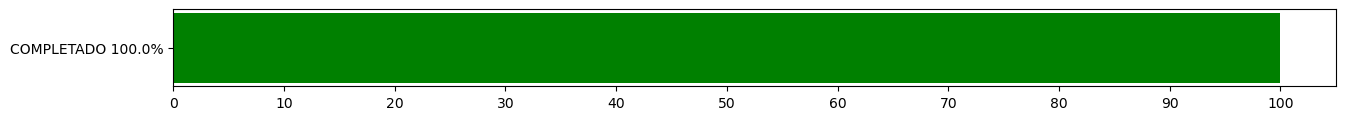

Tiempo transcurrido: 02h : 45min : 27s
CPU times: total: 4min 55s
Wall time: 2h 45min 27s


In [6]:
%%time

# PARÁMETROS: CANTIDAD DE ARTISTAS Y PAIS DE REFERENCIA

data_1, data_2, data_3, data_4, data_5, naciones, paginas = extraer_datos(3_000, "Spain")

## 02. Transform

Para la transformación o manipulación de datos vamos a usar principalmente pandas y NumPy.

Los objetivos principales de esta parte son:

- Limpieza de datos.
- Estructuración de datos.
- Creación de nuevas variables (si aplica).
- Automatización de transformación.

Al igual que la parte anterior, el código debe ser reutilizable para que se pueda aplicar a todos los casos cada vez que se extraiga nueva información.

Al finalizar esta parte debemos tener un DataFrame con la variables de interés que queremos cargar o visualizar, cuidando el tipo de dato de cada variable.

In [7]:
%%time

nombres = list()
oyentes = list()
mbids = list()
urls = list()
biografias = list()
similares = list()
reproducciones = list()
estilos = list()
top_canciones = list()
top_albumes = list()

##### LLENAMOS LAS PRIMERAS COLUMNAS QUE CONFORMARÁN EL DATAFRAME

for pags in range(paginas):
    
    for arts in range(len(data_1[pags]["topartists"]["artist"])):
        
        try:
            nombre = data_1[pags]["topartists"]["artist"][arts]["name"].title()
        except:
            nombre = ""

        try:
            oyente = int(data_1[pags]["topartists"]["artist"][arts]["listeners"])
        except:
            oyente = ""
            
        try:
            if data_1[pags]["topartists"]["artist"][arts]["mbid"] == "":
                mbid = ""
            else:
                mbid = data_1[pags]["topartists"]["artist"][arts]["mbid"]
        except:
            mbid = ""
            
        try:
            url = data_1[pags]["topartists"]["artist"][arts]["url"]
        except:
            url = ""

        nombres.append(nombre)
        oyentes.append(oyente)
        mbids.append(mbid)
        urls.append(url)

##### LLENAMOS LAS SIGUIENTES COLUMNAS QUE SE AÑADIRÁN AL DATAFRAME

for artista in range(len(data_2)):
    
    estilo = list()
    similar = list()
    top_tracks = list()
    discografia = list()
    
    try:
        bio = data_2[artista]["artist"]["bio"]["content"]
    except:
        bio = ""

    try:
        repro = int(data_2[artista]["artist"]["stats"]["playcount"])
    except:
        repro = ""
        
    try:
        for sim in range(len(data_2[artista]["artist"]["similar"]["artist"])):
            similar.append(data_2[artista]["artist"]["similar"]["artist"][sim]["name"])
    except:
        similar.append("")

    try:
        for sim in range(len(data_2[artista]["artist"]["tags"]["tag"])):
            estilo.append(data_2[artista]["artist"]["tags"]["tag"][sim]["name"])
    except:
        estilo.append("")
        
    try:
        for cancion in range(len(data_3[artista]["toptracks"]["track"])):
            dict_top_tracks = dict()
            try:
                dict_top_tracks["track"] = data_3[artista]["toptracks"]["track"][cancion]["name"]
            except:
                dict_top_tracks["track"] = ""
            try:
                dict_top_tracks["reproducciones"] = data_3[artista]["toptracks"]["track"][cancion]["playcount"]
            except:
                dict_top_tracks["reproducciones"] = ""
            top_tracks.append(dict_top_tracks)
    except:
        top_tracks = ""
        
    ##### LLENAMOS LA COLUMNA "ALBUMES TOP" QUE ESTARÁ FORMADA POR MÁS INFORMACIÓN DENTRO
        
    for disco in range(len(data_5[artista])):
        
        albumes = dict()
        tracks = list()
        etiquetas = list()
        
        try:
            albumes["album"] = data_5[artista][disco]["album"]["name"]
        except:
            albumes["album"] = ""
        
        try:
            albumes["reproducciones"] = int(data_5[artista][disco]["album"]["playcount"])
        except:
            albumes["reproducciones"] = ""
        
        try:
            albumes["publicacion"] = data_5[artista][disco]["album"]["wiki"]["published"]
        except:
            albumes["publicacion"] = ""
        
        try:
            for tag in range(len(data_5[artista][disco]["album"]["tags"]["tag"])):
                try:
                    etiquetas.append(data_5[artista][disco]["album"]["tags"]["tag"][tag]["name"])
                except:
                    continue
            albumes["tags"] = etiquetas
        except:
            albumes["tags"] = ""

        try:
            for track in range(len(data_5[artista][disco]["album"]["tracks"]["track"])):
                tema = dict()
                try:
                    tema["titulo"] = data_5[artista][disco]["album"]["tracks"]["track"][track]["name"]
                except:
                    tema["titulo"] = ""

                try:
                    tema["duracion"] = round(int(data_5[artista][disco]["album"]["tracks"]["track"][track]["duration"]) / 60, 2)
                except:
                    tema["duracion"] = ""
                tracks.append(tema)
        except:
            tema = dict()
            tema["titulo"] = ""
            tema["duracion"] = ""
            tracks.append(tema)
        albumes["tracks"] = tracks
        
        discografia.append(albumes)
        
    ##### LLENAMOS LAS LISTAS (FILAS) CON LO ANTERIOR
    
    similares.append(similar)
    estilos.append(estilo)
    biografias.append(bio)
    reproducciones.append(repro)
    top_canciones.append(top_tracks)
    top_albumes.append(discografia)

CPU times: total: 172 ms
Wall time: 426 ms


In [8]:
artistas_top = pd.DataFrame()

In [9]:
# CREAMOS LAS COLUMNAS

artistas_top["ARTISTA"] = nombres
artistas_top["BIOGRAFIA"] = biografias
artistas_top["SIMILARES"] = similares
artistas_top["OYENTES"] = oyentes
artistas_top["REPRODUCCIONES"] = reproducciones
artistas_top["ETIQUETAS"] = estilos
artistas_top["CANCIONES TOP"] = top_canciones
artistas_top["DISCOS TOP"] = top_albumes
artistas_top["PAIS"] = naciones
artistas_top["URL ARTISTA"] = urls
artistas_top["ID ARTISTA"] = mbids

for i in range(len(artistas_top["SIMILARES"])):
    try:
        if len(artistas_top["SIMILARES"][i]) == 0:
            artistas_top["SIMILARES"][i] = np.nan
    except:
        artistas_top["SIMILARES"][i] = np.nan

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3466780148.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artistas_top["SIMILARES"][i] = np.nan


In [10]:
artistas_top

,ARTISTA,BIOGRAFIA,SIMILARES,OYENTES,REPRODUCCIONES,ETIQUETAS,CANCIONES TOP,DISCOS TOP,PAIS,URL ARTISTA,ID ARTISTA
0,David Bowie,David Robert Jones (8 January 1947 – 10 Januar...,"[Tin Machine, Iggy Pop, Lou Reed, Roxy Music, ...",4269011,273029296,"[rock, glam rock, classic rock, 80s, alternative]","[{'track': 'Ziggy Stardust', 'reproducciones':...","[{'album': 'Best of Bowie', 'reproducciones': ...",Reino Unido,https://www.last.fm/music/David+Bowie,5441c29d-3602-4898-b1a1-b77fa23b8e50
1,Coldplay,Coldplay is a British alternative rock and bri...,"[Keane, Imagine Dragons, Travis, OneRepublic, ...",6906287,522126019,"[rock, alternative, britpop, alternative rock,...","[{'track': 'Yellow', 'reproducciones': '207748...","[{'album': 'Parachutes', 'reproducciones': 699...",Reino Unido,https://www.last.fm/music/Coldplay,cc197bad-dc9c-440d-a5b5-d52ba2e14234
2,Queen,Queen is an English rock band originally consi...,"[Freddie Mercury, Brian May, Roger Taylor, Que...",5385083,279396621,"[classic rock, rock, 80s, hard rock, glam rock]","[{'track': 'Bohemian Rhapsody', 'reproduccione...","[{'album': 'Greatest Hits', 'reproducciones': ...",Reino Unido,https://www.last.fm/music/Queen,420ca290-76c5-41af-999e-564d7c71f1a7
3,Radiohead,Radiohead is a English rock band formed in Abi...,"[Thom Yorke, Atoms for Peace, Jeff Buckley, Th...",5999533,721384286,"[alternative, alternative rock, rock, indie, e...","[{'track': 'Creep', 'reproducciones': '2499785...","[{'album': 'OK Computer', 'reproducciones': 11...",Reino Unido,https://www.last.fm/music/Radiohead,a74b1b7f-71a5-4011-9441-d0b5e4122711
4,The Rolling Stones,The Rolling Stones are an English rock band fo...,"[The Who, Keith Richards, The Kinks, The Doors...",4645587,199356097,"[classic rock, rock, british, 60s, blues]","[{'track': 'Paint It Black', 'reproducciones':...","[{'album': 'Let It Bleed', 'reproducciones': 1...",Reino Unido,https://www.last.fm/music/The+Rolling+Stones,b071f9fa-14b0-4217-8e97-eb41da73f598
...,...,...,...,...,...,...,...,...,...,...,...
2995,Lunchmoney Lewis,"Gamal Lewis, better known by his stage name Lu...",NaN,260990,1596222,"[Hip-Hop, pop, soul, rap, american]","[{'track': 'Bills', 'reproducciones': '853443'...","[{'album': 'Bills', 'reproducciones': 684370, ...",Estados Unidos,https://www.last.fm/music/Lunchmoney+Lewis,
2996,Exquirla,,"[El Altar Del Holocausto, Ànteros, Jardín de l...",8498,122110,"[post-rock, Progressive rock, Flamenco, spain,...","[{'track': 'Destruidnos Juntos', 'reproduccion...","[{'album': 'Para Quienes Aún Viven', 'reproduc...",NaN,https://www.last.fm/music/Exquirla,
2997,The Outfield,The Outfield was an arena rock-influenced Brit...,"[Cutting Crew, Rick Springfield, Starship, Mr....",664334,5454727,"[80s, rock, classic rock, pop, british]","[{'track': 'Your Love', 'reproducciones': '406...","[{'album': 'Play Deep', 'reproducciones': 2440...",Reino Unido,https://www.last.fm/music/The+Outfield,5d400869-0471-42ee-afda-3addd73d0418
2998,Alice Coltrane,"Alice Coltrane (née McLeod; August 27, 1937 – ...","[Pharoah Sanders, Sun Ra, Don Cherry, Ornette ...",280379,3643120,"[jazz, free jazz, Avant-Garde, experimental, p...","[{'track': 'Journey in Satchidananda', 'reprod...","[{'album': 'Journey in Satchidananda', 'reprod...",Estados Unidos,https://www.last.fm/music/Alice+Coltrane,d24fc285-7b2f-47da-8ac5-4070b08570b1


In [11]:
artistas_top.to_csv("ARTISTAS_TOP.csv", index = False, sep = ",")

## 03. Load

Para la carga de datos vamos a utilizar una base creada por nosotros en Airtable.

El objetivo principal de esta parte es:

- Automatizar el proceso de carga de datos de Airtable.
- Automatizar el proceso de extracción de datos de Airtable.

Para esta parte debemos hacer dos funciones: una para cargar datos a una tabla y una para extraer los datos de esa tabla.

El proceso debe ser automatizado y usando el API de Airtable.

##### CARGA DE DATOS

In [12]:
API_KEY = "YOUR_API_KEY"
BASE_ID = "YOUR_BASE_ID"
TABLE_ID_1000 = "YOUR_TABLE_ID"
TABLE_ID_3000 = "YOUR_TABLE_ID"

airtable_base_url = "https://api.airtable.com/v0"

headers = {"Authorization" : f"Bearer {API_KEY}",
           "Content-Type"  : "application/json"}

endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID_3000}"

In [13]:
artistas_top.fillna("", inplace = True)

In [14]:
%%time

data = [{"fields" : artistas_top.iloc[i, :].to_dict()} for i in range(artistas_top.shape[0])]

for i in range(0, artistas_top.shape[0], 10):
    
    datos_subir = {"records" : data[i : i + 10], "typecast" : True}
    
    response = requests.post(url = endpoint, headers = headers, json = datos_subir)
    
    print(f"({i + 10}) : {response.status_code}")

(10) : 200
(20) : 200
(30) : 200
(40) : 200
(50) : 200
(60) : 200
(70) : 200
(80) : 200
(90) : 200
(100) : 200
(110) : 200
(120) : 200
(130) : 200
(140) : 200
(150) : 200
(160) : 200
(170) : 200
(180) : 200
(190) : 200
(200) : 200
(210) : 200
(220) : 200
(230) : 200
(240) : 200
(250) : 200
(260) : 200
(270) : 200
(280) : 200
(290) : 200
(300) : 200
(310) : 200
(320) : 200
(330) : 200
(340) : 200
(350) : 200
(360) : 200
(370) : 200
(380) : 200
(390) : 200
(400) : 200
(410) : 200
(420) : 200
(430) : 200
(440) : 200
(450) : 200
(460) : 200
(470) : 200
(480) : 200
(490) : 200
(500) : 200
(510) : 200
(520) : 200
(530) : 200
(540) : 200
(550) : 200
(560) : 200
(570) : 200
(580) : 200
(590) : 200
(600) : 200
(610) : 200
(620) : 200
(630) : 200
(640) : 200
(650) : 200
(660) : 200
(670) : 200
(680) : 200
(690) : 200
(700) : 200
(710) : 200
(720) : 200
(730) : 200
(740) : 200
(750) : 200
(760) : 200
(770) : 200
(780) : 200
(790) : 200
(800) : 200
(810) : 200
(820) : 200
(830) : 200
(840) : 200
(

##### DESCARGA DE DATOS

In [15]:
%%time

params = {}

cont = 100

endpoint = f"{airtable_base_url}/{BASE_ID}/{TABLE_ID_3000}"

datos = list()

while params.get("offset") != None or len(datos) == 0:
    
    response = requests.get(url = endpoint, headers = headers, params = params)
    
    print(f"({cont}) : {response.status_code}")
    
    data = response.json()
    
    offset = data.get("offset")
    
    params["offset"] = offset
    
    datos.extend(data["records"])
    
    cont += 100
    
print(len(datos))

(100) : 200
(200) : 200
(300) : 200
(400) : 200
(500) : 200
(600) : 200
(700) : 200
(800) : 200
(900) : 200
(1000) : 200
(1100) : 200
(1200) : 200
(1300) : 200
(1400) : 200
(1500) : 200
(1600) : 200
(1700) : 200
(1800) : 200
(1900) : 200
(2000) : 200
(2100) : 200
(2200) : 200
(2300) : 200
(2400) : 200
(2500) : 200
(2600) : 200
(2700) : 200
(2800) : 200
(2900) : 200
(3000) : 200
3000
CPU times: total: 672 ms
Wall time: 24.4 s


In [16]:
artistas_top_airtable = pd.DataFrame()

for i in range(len(datos)):
    
    artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  artistas_top_airtable = artistas_top_airtable.append(datos[i]["fields"], ignore_index = True)
C:\Users\Aa\AppData\Local\Temp\ipykernel_7208\3712225805.py:5: FutureWarning: The frame.append method is deprecated and will

In [17]:
artistas_top_airtable

,ARTISTA,BIOGRAFIA,SIMILARES,OYENTES,REPRODUCCIONES,ETIQUETAS,CANCIONES TOP,DISCOS TOP,PAIS,URL ARTISTA,ID ARTISTA
0,Pat Metheny,Patrick Bruce Metheny (born 12 August 1954 in ...,"[Pat Metheny Group, Lyle Mays, Pat Metheny & L...",422773,7616154,"[jazz, Fusion, guitar, jazz guitar, jazz fusion]","[\n {\n ""track"": ""Bright Size Life"",...","[\n {\n ""album"": ""Bright Size Life"",...",Estados Unidos,https://www.last.fm/music/Pat+Metheny,7daac7f9-8fcc-485f-a14f-f8091d98cf25
1,Enrique Iglesias,Enrique Iglesias (born Enrique Miguel Iglesias...,"[Ricky Martin, Luis Fonsi, Chayanne, Reik, Bos...",1979969,35915105,"[pop, latin, spanish, dance, latin pop]","[\n {\n ""track"": ""Hero"",\n ""r...","[\n {\n ""album"": ""Escape"",\n ...",España,https://www.last.fm/music/Enrique+Iglesias,35f866dc-c061-48ba-8157-cf2e0eac4857
2,Yazoo,Yazoo was an English synthpop duo from Basildo...,"[Erasure, The Human League, Orchestral Manoeuv...",744514,7056939,"[80s, new wave, synthpop, electronic, synth pop]","[\n {\n ""track"": ""Don't Go"",\n ...","[\n {\n ""album"": ""Upstairs at Eric's...",NaN,https://www.last.fm/music/Yazoo,42922db2-2e80-44b8-9cdf-0b3a6634c124
3,Marshmello,"Chris Comstock, better known by his stage name...","[The Chainsmokers, Martin Garrix, Alan Walker,...",1467522,34058957,"[electronic, dance, trap, EDM, pop]","[\n {\n ""track"": ""Happier"",\n ...","[\n {\n ""album"": ""Happier"",\n ...",Estados Unidos,https://www.last.fm/music/Marshmello,NaN
4,Café Tacvba,Café Tacvba (often spelled Café Tacuba*) is a...,"[Caifanes, Fobia, El Gran Silencio, Jaguares, ...",461035,14259031,"[latin, mexico, alternative rock, rock, Rock e...","[\n {\n ""track"": ""Eres"",\n ""r...","[\n {\n ""album"": ""Cuatro Caminos"",\n...",México,https://www.last.fm/music/Caf%C3%A9+Tacvba,c2b37a39-c66a-44b2-b190-a69485ae5d95
...,...,...,...,...,...,...,...,...,...,...,...
2995,Amparanoia,Amparanoia is the musical project of the Spani...,"[Sergent Garcia, Ojos de Brujo, La Pegatina, C...",165384,1386193,"[spanish, latin, Fusion, world, patchanka]","[\n {\n ""track"": ""Don't Leave Me Now...","[\n {\n ""album"": ""La Vida Te Da"",\n ...",NaN,https://www.last.fm/music/Amparanoia,7c61d54d-90fd-42e2-929a-9398a2a24269
2996,Spin Doctors,The Spin Doctors is a rock group from New York...,"[Gin Blossoms, Deep Blue Something, Hootie & T...",974607,6602543,"[rock, alternative rock, 90s, alternative, pop]","[\n {\n ""track"": ""Two Princes"",\n ...","[\n {\n ""album"": ""Pocket Full Of Kry...",Estados Unidos,https://www.last.fm/music/Spin+Doctors,1bcb61f3-ca9c-4a26-b16e-0547ad6c21be
2997,The Shoes,There are at least six artists known as The Sh...,"[Yuksek, Vitalic, Mr. Oizo, Sébastien Tellier,...",231152,2311948,"[electronic, french, electro, indie, seen live]","[\n {\n ""track"": ""Time to Dance"",\n ...","[\n {\n ""album"": ""Crack My Bones"",\n...",NaN,https://www.last.fm/music/The+Shoes,f527fc42-5905-4f48-976f-717080455ff9
2998,Caloncho,"Óscar Alfonso Castro (born December 20, 1986 i...","[Little Jesus, León Larregui, Jósean Log, Reyn...",92655,1332377,"[folk, spanish, mexico, latin, indie]","[\n {\n ""track"": ""Palmar"",\n ...","[\n {\n ""album"": ""Bálsamo"",\n ...",NaN,https://www.last.fm/music/Caloncho,NaN


## 04. Visualization y 05. Storytelling

- Estos capítulos los encontrarás en el notebook: Proyecto_1_Lastfm_api_VISUALIZATION-STORYTELLING